In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 고흐가 그린 꽃은 어떤 꽃일까 ? KNN

ebs 수학과 함께하는 AI 기초 pg 110

#### 데이터 가져오기

In [2]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn]))) import io
iris = pd.read_csv(io.StringIO(uploaded['Iris.csv'].decode('utf-8')), dtype = str)
iris

Saving Iris.csv to Iris.csv
User uploaded file "Iris.csv" with length 5107 bytes


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [3]:
iris[['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']] = iris[['SepalLengthCm','SepalWidthCm','PetalLengthCm','PetalWidthCm']].astype(float)

In [4]:
iris.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
iris.info() # iris 전체 데이터 요약한 것 출력

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             150 non-null    object 
 1   SepalLengthCm  150 non-null    float64
 2   SepalWidthCm   150 non-null    float64
 3   PetalLengthCm  150 non-null    float64
 4   PetalWidthCm   150 non-null    float64
 5   Species        150 non-null    object 
dtypes: float64(4), object(2)
memory usage: 7.2+ KB


In [6]:
iris.describe() # iris 전체 데이터의 통계값 요약 출력

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


#### 그래프 그리기

##### 꽃받침 길이 vs 너비

In [7]:
iris['color'] = np.where(iris.Species == 'Iris-setosa', 'red', np.where(iris.Species =='Iris-versicolor', 'green', 'blue'))

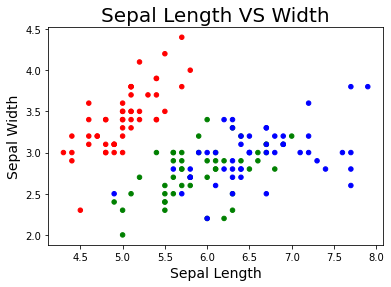

In [8]:
iris.plot(kind='scatter',
          x='SepalLengthCm',
          y='SepalWidthCm',
          c=iris['color'])

plt.title('Sepal Length VS Width', fontsize=20)
plt.xlabel('Sepal Length', fontsize=14)
plt.ylabel('Sepal Width', fontsize=14)
plt.show()

##### 꽃잎의 길이 vs 너비

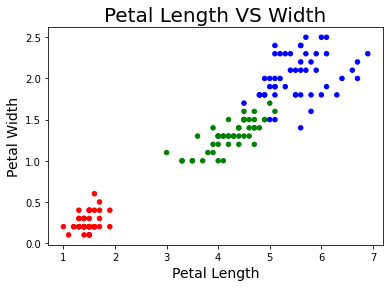

In [9]:
iris.plot(kind='scatter',
          x='PetalLengthCm',
          y='PetalWidthCm',
          c=iris['color'])

plt.title('Petal Length VS Width', fontsize=20)
plt.xlabel('Petal Length', fontsize=14)
plt.ylabel('Petal Width', fontsize=14)
plt.show()

#### KNN 알고리즘

def 붓꽃 분류기(분류하고 싶은 데이터, 분류된 데이터, K) :
  1. 분류하고 싶은 데이터와 분류된 데이터 사이의 거리 계산하기
  2. 분류하고 싶은 데이터와 가까운 순서대로 나열하기
  3. 가장 가까운 K개 데이터 중에서 레이블별 빈도 세기
  4. return 최다 빈도의 붓꽃 레이블값 반환하기

In [10]:
# 계산의 편의를 위해 데이터 셋의 형식을 numpy로 변환
xy = np.array(iris)

'''
꽃 종류는 뒤에서 두번째 벡터에 있다.
그래프 그릴 때 마지막 열에는 red, blue, green 색을 넣었기 때문에!!!
'''
features = xy[:,1:-2]
# 테이블의 마지막 열 벡터를 target_value에 저장
target_value = xy[:,[-2]]

In [11]:
# 거리를 계산하는 함수 만들기
def Distance(A,B) :
  return np.sqrt(np.sum(np.power((A-B),2)))

In [12]:
def K_NN(Unknown, features, K) :
  # 1. 데이터 사이의 거리 계산
  distance_result = np.zeros(len(features))
  for i in range(len(features)) :
    distance_result[i] = Distance(Unknown, features[i])

  # 2. 분류하려는 데이터와 가까운 순서대로 인덱스 정렬
  index = distance_result.argsort()

  # 3. K개의 레이블별 빈도 세기
  target_result = []
  result = [0,0,0]
  for i in range(K) :
    target_result.append(target_value[index[i]])
    if target_result[i] == 'Iris-setosa':
      result[0] += 1
    elif target_result[i] == 'Iris-versicolor':
      result[1] += 1
    else :
      result[2] += 1
 
  # 4. 레이블의 빈도가 가장 높은 값 반환
  max_label = result.index(max(result))
  species = {0 : 'setosa', 1:'versicolor', 2:'virginica'}
  species_result = species[max_label]
  return species_result

In [13]:
# argsort() 함수 알아보기
# 기능 : 작은 값부터 순서대로 데이터의 index를 반환함
sample = np.array([10,2,1,5])
result = sample.argsort()
# result에는 [1의 인덱스, 2의 인덱스, 5의 인덱스, 10의 인덱스]가 들어가게 됨
print(result)
print('가장 작은 값은 {0}이며, 인덱스 번호는 {1}입니다.'.format(sample[result[0]],result[0]))

[2 1 3 0]
가장 작은 값은 1이며, 인덱스 번호는 2입니다.


In [14]:
# 붓꽃 분류 함수를 사용하여 가상의 데이터 분류하기
# 마지막 데이터
test_1 = features[-1]

# 마지막 데이터와 유사한 가상의 데이터
test_2 = np.array([6,2.9,5,2])

# KNN으로 분류하기
result_1 = K_NN(test_1,features,3)
result_2 = K_NN(test_2, features, 3)

# 결과 출력
print('실제 데이터를 분류한 결과 : {0}'.format(result_1))
print('가상 데이터를 분류한 결과 : {0}'.format(result_2))

실제 데이터를 분류한 결과 : virginica
가상 데이터를 분류한 결과 : virginica


In [15]:
# 고흐가 그린 붓꽃 그림의 데이터 분류하기
# 그림에서 수집한 데이터
ID_1 = np.array([2.7,2.4,1.65,0.67])
ID_2 = np.array([5.84, 5.48, 3, 2.16])
ID_3 = np.array([3.97,4.01,1.7,0.67])

# K_NN 분류 함수를 이용하여 분류하기
result_1 = K_NN(ID_1, features , 5)
result_2 = K_NN(ID_2, features, 5)
result_3 = K_NN(ID_3, features, 5)

# 분류 결과 출력하기
print(result_1, result_2, result_3)

setosa setosa setosa


# 교재 따라치기

#### merge

In [16]:
# merge
code = {'CODE' :['A','B','C','D','E'], 'NAME':['아','비','씨','디','이']}
code2 = {'CODE':['A','B','C','X','Y'], 'VALUE' : ['1','2','3','4','5']}
tf = pd.DataFrame.from_dict(code)
vf = pd.DataFrame.from_dict(code2)
pd.merge(tf,vf) # 동일 칼럼명인 CODE 기준으로 INNER JOIN 처리

,CODE,NAME,VALUE
0,A,아,1
1,B,비,2
2,C,씨,3


In [17]:
# inner join
df1 = pd.DataFrame.from_dict(code)
df2 = pd.DataFrame.from_dict(code2)

rf=pd.merge(df1,df2,on=['CODE'],how = 'inner') # how를 지정하지 않으면 inner로 동작
rf

,CODE,NAME,VALUE
0,A,아,1
1,B,비,2
2,C,씨,3


In [18]:
# left join
rf = pd.merge(df1, df2, on=['CODE'],how='left')
rf

,CODE,NAME,VALUE
0,A,아,1
1,B,비,2
2,C,씨,3
3,D,디,NaN
4,E,이,NaN


In [19]:
# right join
rf = pd.merge(df1, df2, on=['CODE'],how='right')
rf

,CODE,NAME,VALUE
0,A,아,1
1,B,비,2
2,C,씨,3
3,X,NaN,4
4,Y,NaN,5


In [20]:
# outer join
rf = pd.merge(df1, df2, on=['CODE'],how='outer')
rf

,CODE,NAME,VALUE
0,A,아,1
1,B,비,2
2,C,씨,3
3,D,디,NaN
4,E,이,NaN
5,X,NaN,4
6,Y,NaN,5


#### groupby

In [21]:
df = pd.DataFrame(np.array([70,20000,70,50000,90,50000]).reshape(3,2),columns = ['성능','가격'])
df.groupby('성능').sum()

,가격
성능,
70,70000
90,50000


In [22]:
df.groupby('성능').mean()

,가격
성능,
70,35000
90,50000


In [23]:
df.groupby('성능').count()

,가격
성능,
70,2
90,1


#### pivot table

In [24]:
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn]))) import io
df = pd.read_csv(io.StringIO(uploaded['student_exam_result'].decode('utf-8')), dtype = str)
df

Saving student_exam_result to student_exam_result
User uploaded file "student_exam_result" with length 12265 bytes


,이름,과목,점수,재시험회수,합격여부
0,이혜원,과학,90,3,Passed
1,김현서,과학,75,1,Passed
2,박지유,국어,51,2,Failed
3,태시아,국어,51,2,Failed
4,김수아,수학,32,2,Failed
...,...,...,...,...,...
402,정채윤,철학,54,1,Failed
403,박다현,철학,39,3,Failed
404,박소연,철학,87,2,Passed
405,정소율,철학,84,1,Passed


In [25]:
df.columns

Index(['이름', '과목', '점수', '재시험회수', '합격여부'], dtype='object')

In [26]:
df[['점수','재시험회수']] = df[['점수','재시험회수']].astype(int)

In [27]:
# aggfunc는 default로 np.means 지정 숫자인 '재시험회수','점수'의 평균이 출력된다.
df.pivot_table(index=['합격여부'])

,재시험회수,점수
합격여부,,
Failed,2.079439,47.892523
Passed,1.891192,84.284974


In [28]:
# index로 '과목'과 '합격여부'를 지정하면 멀티 index로 지정된다.
df.pivot_table(index=['과목','합격여부'])

재시험회수         점수
과목 합격여부                       
과학 Failed  2.156250  65.281250
   Passed  2.014706  85.911765
국어 Failed  2.261905  59.500000
   Passed  1.793103  84.379310
수학 Failed  2.000000  42.491525
   Passed  1.756098  83.463415
영어 Failed  2.012987  38.103896
   Passed  2.043478  80.739130
철학 Failed  2.000000  55.000000
   Passed  1.666667  84.000000

In [29]:
# columns에 지정된 칼럼은 카테고리화 되는데, 이 때 수치 값을 가지는 칼럼의 하위 그룹핑된다.
# 재시험 회수는 1,2,3 값으로 분포되어 있고, columns에 지정되어 '점수' 하위 칼럼으로 재매핑된다.
df.pivot_table(index=['과목','합격여부'], columns = ['재시험회수'])

점수                      
재시험회수              1          2          3
과목 합격여부                                   
과학 Failed  64.375000  66.181818  65.076923
   Passed  86.120000  86.529412  85.307692
국어 Failed  56.625000  60.400000  60.000000
   Passed  84.666667  85.000000  82.666667
수학 Failed  42.434783  44.461538  41.434783
   Passed  85.578947  81.307692  82.111111
영어 Failed  38.500000  37.214286  38.720000
   Passed  82.750000  80.214286  80.600000
철학 Failed  54.000000  63.500000  39.000000
   Passed  84.000000  84.000000        NaN

In [30]:
# 멀티 인덱스와 같이 멀티 칼럼도 가능하다.
# df.pivot_table(index=['과목','합격여부'], columns=['재시험회수'])
df.pivot_table(index=['과목'],columns= ['합격여부','재시험회수']) # 합격 여부를 칼럼으로 옮겨서 표현

점수                                                       
합격여부      Failed                           Passed                      
재시험회수          1          2          3          1          2          3
과목                                                                     
과학     64.375000  66.181818  65.076923  86.120000  86.529412  85.307692
국어     56.625000  60.400000  60.000000  84.666667  85.000000  82.666667
수학     42.434783  44.461538  41.434783  85.578947  81.307692  82.111111
영어     38.500000  37.214286  38.720000  82.750000  80.214286  80.600000
철학     54.000000  63.500000  39.000000  84.000000  84.000000        NaN

In [31]:
# 각 칼럼들의 수치 연산은 axis=1 옵션을 통해 처ㅓ리가 가능하다. (입력하지 않으면 row 기준합계)
# 합격여부, 재시험 회수에 해당하는 인원수로 묶기
tf = df.pivot_table(index=['과목'], columns = ['합격여부','재시험회수'],aggfunc=len)[['점수']]
tf['합계'] = tf['점수'].sum(axis=1) #새로운 칼럼 '합계'로 결과 저장
tf

점수                                    합계
합격여부  Failed             Passed                   
재시험회수      1     2     3      1     2     3       
과목                                                
과학       8.0  11.0  13.0   25.0  17.0  26.0  100.0
국어       8.0  15.0  19.0   24.0  22.0  12.0  100.0
수학      23.0  13.0  23.0   19.0  13.0   9.0  100.0
영어      24.0  28.0  25.0    4.0  14.0   5.0  100.0
철학       1.0   2.0   1.0    1.0   2.0   NaN    7.0

In [32]:
# aggfunc를 len으로 하는 것과 count로 하는 것이 같을 것 같아서 실행해봄..!
tf = df.pivot_table(index=['과목'], columns = ['합격여부','재시험회수'],aggfunc='count')[['점수']]
tf['합계'] = tf['점수'].sum(axis=1) #새로운 칼럼 '합계'로 결과 저장
tf

점수                                    합계
합격여부  Failed             Passed                   
재시험회수      1     2     3      1     2     3       
과목                                                
과학       8.0  11.0  13.0   25.0  17.0  26.0  100.0
국어       8.0  15.0  19.0   24.0  22.0  12.0  100.0
수학      23.0  13.0  23.0   19.0  13.0   9.0  100.0
영어      24.0  28.0  25.0    4.0  14.0   5.0  100.0
철학       1.0   2.0   1.0    1.0   2.0   NaN    7.0

#### stack과 unnstack

stack : 상단 헤더 칼럼들을 index 기준으로 각각 재그릅화 (기존 인덱스의 하위 레벨로 그룹핑)
   
unstack : 멀티 인덱스를 칼럼 기준으로 재그룹화 시키는 방법 (기존 헤더의 하위 레벨로 그룹핑)

In [33]:
_f = pd.DataFrame([[1,'A'],[2,'B']],columns = ['C1','C2'],index=['l1','l2'])
_f

,C1,C2
l1,1,A
l2,2,B


In [34]:
_f.stack()

l1  C1    1
    C2    A
l2  C1    2
    C2    B
dtype: object

In [35]:
_f.stack().unstack()

,C1,C2
l1,1,A
l2,2,B
